# Independent component analysis reduction of all COI

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load common_.py
from common import *

In [59]:
# export
from ehv import core, load as e_load, correlation
from matplotlib import cm
import matplotlib
from sklearn.preprocessing import scale, robust_scale, minmax_scale
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import FastICA, PCA, KernelPCA

In [39]:
samples = None
# samples = pandas.read_csv("data/selected_samples.csv")
df = e_load.load_raw_ideas_dir(
    Path("/data/weizmann/EhV/high_time_res"), 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ideas_features/"), 
    "ALL", 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/cell_populations/manual_gating/"),
    samples, "Low/*.cif")
df = e_load.remove_unwanted_features(df)
df = e_load.tag_columns(df)
df = e_load.clean_column_names(df)

df = df[df["meta_label_coi"]]
df.shape

import re
reg = r"^meta_label_(.+)$"
label_vec = numpy.full((df.shape[0]), fill_value="unknown", dtype=object)
for col in df.filter(regex="(?i)meta_label_.*psba.*"):
    label_vec[df[col].values] = re.match(reg, col).groups(1)
    
df["meta_label"] = label_vec

df = df.reset_index(drop=True)

In [40]:
orig_df = df.copy()

In [41]:
correlated_features = correlation.get_correlated_features(df.filter(regex="feat"), thresh=0.92)
df = df.drop(columns=correlated_features)
df.shape

(339045, 94)

In [61]:
def do_minmax_scale(df):
    df[df.filter(regex="feat").columns] = minmax_scale(df.filter(regex="feat"))
    return df

df = df.groupby(["meta_timepoint", "meta_replicate"]).apply(do_minmax_scale)

In [62]:
def do_zscore_scale(df):
    df[df.filter(regex="feat").columns] = scale(df.filter(regex="feat"))
    return df

df = df.groupby(["meta_timepoint", "meta_replicate"]).apply(do_zscore_scale)

In [42]:
def do_robust_scale(df):
    df[df.filter(regex="feat").columns] = robust_scale(df.filter(regex="feat"), quantile_range=(0.05, 0.95))
    return df

df = df.groupby(["meta_timepoint"]).apply(do_robust_scale)

In [54]:
def do_median_centering(df):
    df[df.filter(regex="feat").columns] -= df.median()
    return df

df = df.groupby(["meta_timepoint", "meta_replicate"]).apply(do_median_centering)

In [81]:
def do_mean_centering(df):
    df[df.filter(regex="feat").columns] -= df.mean()
    return df

df = df.groupby(["meta_timepoint"]).apply(do_mean_centering)

In [82]:
model = FastICA(n_components=3, random_state=42)

In [43]:
model = PCA(n_components=0.95, random_state=42)

In [61]:
projection = model.fit_transform(df.filter(regex="feat"))

MemoryError: Unable to allocate 856. GiB for an array with shape (339045, 339045) and data type float64

In [ ]:
projection.shape

In [41]:
dump(projection, "/data/weizmann/EhV/weizmann-ehv-metadata/representations/ica/Low/%s.dat" % uuid.uuid4())

['/data/weizmann/EhV/weizmann-ehv-metadata/representations/ica/Low/5f0e7f37-8891-4b46-a6e7-52838a6f74db.dat']

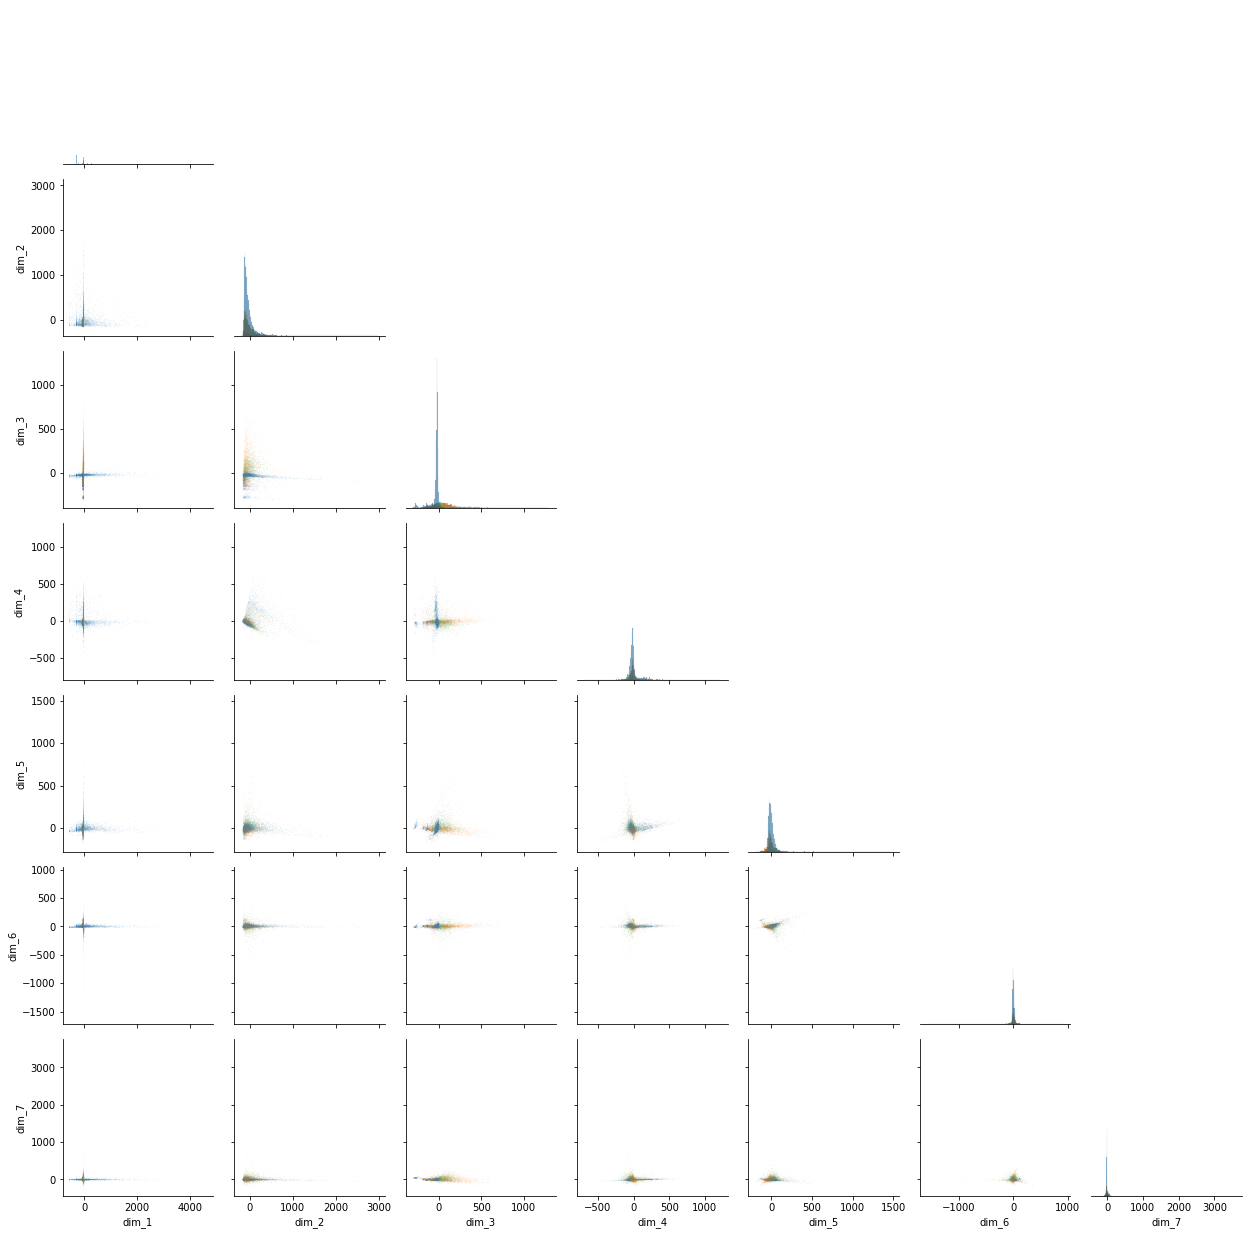

In [57]:
proj_df = pandas.DataFrame(data=projection, columns=["dim_%d" % (i+1) for i in range(projection.shape[1])])
tmp_df = pandas.concat([df, proj_df], axis=1)[df["meta_label"] != "unknown"].sample(n=10000)

grid = seaborn.PairGrid(
    data=tmp_df,
    vars=tmp_df.filter(regex="dim_[0-9]+$").columns, 
    hue="meta_label", hue_order=["mcp_neg_psba_pos", "mcp_pos_psba_pos", "mcp_pos_psba_neg", "mcp_neg_psba_neg"],
    corner=True
)
grid.map_lower(seaborn.scatterplot, s=0.1, alpha=0.5, edgecolors="none")
grid.map_diag(seaborn.histplot)